# Starbucks Capstone Project : Background

## Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. Not all users receive the same offer, and that is the challenge to solve with this data set.

The goal is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

The transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

We need to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

## Data

The data is contained in three files:

**portfolio.json**
containing offer ids and meta data about each offer (duration, type, etc.)

* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
demographic data for each customer

* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
records for transactions, offers received, offers viewed, and offers completed

* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

# Data Cleaning

## Import packages

In [1]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from scipy import stats

%matplotlib inline 
#there must be no space between % and matplotlib to make it work 

In [2]:
# multi-line output 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
# hide warnings - comment to disable
import warnings
warnings.filterwarnings('ignore')

## Read in data

In [4]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## Portfolio Data (final data saved in df_offers)
Portfolio data contains offer-related information

### Dimensions, missing data, and data types
There are 10 unique offers in the dataset and 0 missing value. 

- offer_type: bogo, informational, and discount
- difficulty: ranges from 0-20 
- duration: ranges from 3-10 days 

In [5]:
portfolio.shape # check shape 
portfolio.head() # check top rows 
portfolio.isnull().mean() # check missing value percentages 

(10, 6)

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


reward        0.0
channels      0.0
difficulty    0.0
duration      0.0
offer_type    0.0
id            0.0
dtype: float64

In [6]:
portfolio.dtypes

reward         int64
channels      object
difficulty     int64
duration       int64
offer_type    object
id            object
dtype: object

In [7]:
portfolio.offer_type.value_counts()

discount         4
bogo             4
informational    2
Name: offer_type, dtype: int64

In [8]:
portfolio.describe()

,reward,difficulty,duration
count,10.000000,10.000000,10.000000
mean,4.200000,7.700000,6.500000
std,3.583915,5.831905,2.321398
min,0.000000,0.000000,3.000000
25%,2.000000,5.000000,5.000000
50%,4.000000,8.500000,7.000000
75%,5.000000,10.000000,7.000000
max,10.000000,20.000000,10.000000


### Reshape offer channel list to individual columns
Offer channel has multiple channel names all clustered together. We will break it down to `has_email`, `has_web`,`has_mobile`,`has_social`

In [9]:
# channel to columns
portfolio.channels.value_counts()

[web, email, mobile, social]    4
[web, email, mobile]            3
[email, mobile, social]         2
[web, email]                    1
Name: channels, dtype: int64

In [10]:
portfolio['has_email']=portfolio.channels.apply(lambda x:1 if 'email'in x else 0)
portfolio['has_web']=portfolio.channels.apply(lambda x:1 if 'web'in x else 0)
portfolio['has_mobile']=portfolio.channels.apply(lambda x:1 if 'mobile'in x else 0)
portfolio['has_social']=portfolio.channels.apply(lambda x:1 if 'social'in x else 0)
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id,has_email,has_web,has_mobile,has_social
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,0,1,1
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,1,0
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,0


### Differences among offer_types, in reward, difficulty, and marketing channels?

In [11]:
portfolio.groupby('offer_type')[['reward','difficulty','duration','has_email','has_web','has_mobile','has_social']].mean()

,reward,difficulty,duration,has_email,has_web,has_mobile,has_social
offer_type,,,,,,,
bogo,7.5,7.50,6.0,1.0,0.75,1.00,0.75
discount,3.0,11.75,8.5,1.0,1.00,0.75,0.50
informational,0.0,0.00,3.5,1.0,0.50,1.00,0.50


Among the three offer_types, bogo offers has the highest reward, discount offer has the highest difficulty and longest duration. All offers are sent by email. Informational offer has the lowest difficulty and lowest duration.

### Dummy code offer_type
Offer_type is a categorical variable, not suitable for modeling. So we create dummy code for each offer type

In [12]:
#dummy code offer_type
offer_type_dummy = pd.get_dummies(portfolio.offer_type).rename(columns={'bogo':'is_bogo','discount':'is_discount','informational':'is_informational'})
portfolio_dummy = pd.concat([offer_type_dummy,portfolio[['reward','difficulty','duration','id','has_email','has_web','has_mobile','has_social']]],axis=1)

In [13]:
portfolio_dummy.sample()

,is_bogo,is_discount,is_informational,reward,difficulty,duration,id,has_email,has_web,has_mobile,has_social
8,1,0,0,5,5,5,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1


### Convert duration in days to hours
Since duration (how long the offer is valid for) is recorded by day, we are going to change it to hours and store in `duration_hours` column

In [14]:
portfolio_dummy['duration_hours']=portfolio_dummy['duration']*24

### Save the portfoio data in `df_offers` and rename variables
 

In [15]:
df_offers = portfolio_dummy.drop('duration',axis=1).rename(columns={'id':'offer_id'})
df_offers.sample(5)

,is_bogo,is_discount,is_informational,reward,difficulty,offer_id,has_email,has_web,has_mobile,has_social,duration_hours
8,1,0,0,5,5,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1,120
3,1,0,0,5,5,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0,168
6,0,1,0,2,10,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1,240
2,0,0,1,0,0,3f207df678b143eea3cee63160fa8bed,1,1,1,0,96
4,0,1,0,5,20,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,0,240


## Profile data (final data saved in df_customers)
Profile data contains demographic data for each customer. 

### Examine missing values, datatypes, and shape
There are 17000 rows. Only gender and age columns have about 13% of missing values. We also noticed that `became_member_on` is an int, which will be converted to datetime type later

In [16]:
profile.shape
profile.head()
profile.dtypes

(17000, 5)

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


gender               object
age                   int64
id                   object
became_member_on      int64
income              float64
dtype: object

In [17]:
profile.isnull().mean()

gender              0.127941
age                 0.000000
id                  0.000000
became_member_on    0.000000
income              0.127941
dtype: float64

### Convert `became_member_on` to DateTime

In [18]:
profile['became_member_on'] = profile['became_member_on'].astype(str)

In [19]:
# fix became_member_on datatype
profile['became_member_on'] = profile['became_member_on'].apply(lambda x:datetime(year=int(x[0:4]),
                          month=int(x[4:6]),day=int(x[6:8]))) 

(array([ 343.,  362.,  326.,  362., 1658., 1795., 1715., 1748., 5135.,
        3556.]),
 array([735078. , 735260.3, 735442.6, 735624.9, 735807.2, 735989.5,
        736171.8, 736354.1, 736536.4, 736718.7, 736901. ]),
 <a list of 10 Patch objects>)

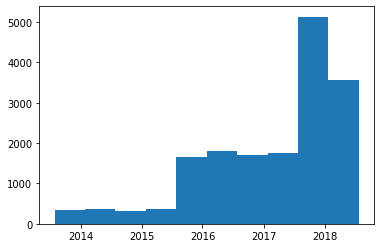

In [20]:
plt.hist(profile.became_member_on)

We noticed that most customers became members in 2018. The distribution is very skewed.

### Clean odd ages

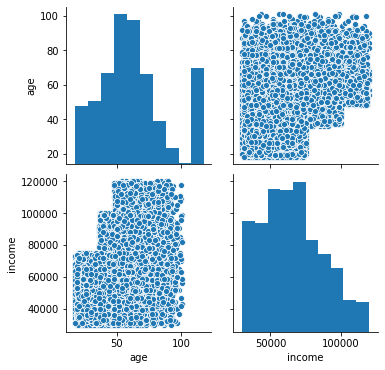

In [21]:
sns.pairplot(profile)

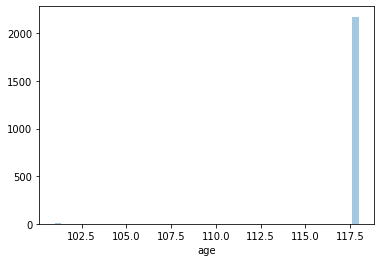

In [22]:
# looks like when age >100, the income values are missing
# based on the graph above, we will set the cutoff to 115
sns.distplot(profile[profile.age>100].age,kde=False)


In [23]:
# see percentages of missing values
#  confirm these rows do not contain useful information
profile[profile.age>115].isnull().mean()

gender              1.0
age                 0.0
id                  0.0
became_member_on    0.0
income              1.0
dtype: float64

In [24]:
# save clean profile data in profile_clean
profile_clean = profile[profile.age<115]
profile_clean.shape

(14825, 5)

### Compute membership_days

In [25]:
# compute membership_days
since_date = profile_clean.became_member_on.max()
profile_clean['membership_days'] = (since_date -profile_clean['became_member_on'])/np.timedelta64(1, 'D')
profile_clean.membership_days.describe()

count    14825.000000
mean       522.478988
std        419.205158
min          0.000000
25%        208.000000
50%        358.000000
75%        797.000000
max       1823.000000
Name: membership_days, dtype: float64

In [26]:
profile_clean.drop(['became_member_on'],inplace=True,axis=1)
profile_clean.head()

,gender,age,id,income,membership_days
1,F,55,0610b486422d4921ae7d2bf64640c50b,112000.0,376.0
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,100000.0,443.0
5,M,68,e2127556f4f64592b11af22de27a7932,70000.0,91.0
8,M,65,389bc3fa690240e798340f5a15918d5c,53000.0,167.0
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,257.0


### Dummy Code Gender
There are about 57% male customers, 41% female customers, and 1.4% customers in other gender groups.

M    0.572277
F    0.413423
O    0.014300
Name: gender, dtype: float64

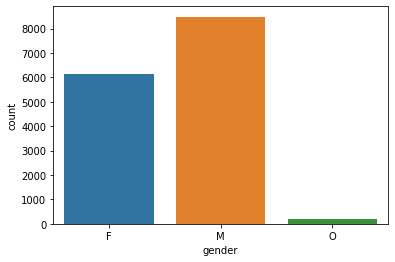

In [27]:
# Gender distribution
sns.countplot(x='gender',data=profile_clean)
profile_clean.gender.value_counts()/profile_clean.shape[0] # to compute percentages

In [28]:
# dummy_code gender 
gender_dummy_coded = pd.get_dummies(profile_clean.gender).rename(columns ={'F':'is_female','M':'is_male'})
profile_clean = pd.concat([profile_clean[['id','income','membership_days','age']],gender_dummy_coded[['is_female','is_male']]],axis=1)
profile_clean.head()

,id,income,membership_days,age,is_female,is_male
1,0610b486422d4921ae7d2bf64640c50b,112000.0,376.0,55,1,0
3,78afa995795e4d85b5d9ceeca43f5fef,100000.0,443.0,75,1,0
5,e2127556f4f64592b11af22de27a7932,70000.0,91.0,68,0,1
8,389bc3fa690240e798340f5a15918d5c,53000.0,167.0,65,0,1
12,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,257.0,58,0,1


### Save clean profile data in df_customers

In [29]:
df_customers = profile_clean.rename(columns={'id':'customer_id'})
df_customers.sample(2)

,customer_id,income,membership_days,age,is_female,is_male
8392,636f585d6b924f29bd263e7cebb3ec90,70000.0,308.0,29,0,1
9026,2c28280400be4ffd86ee4caef0b759f7,77000.0,219.0,62,1,0


## Segment Transcript Data

### Data shape, types, and missing values
There are no missing values. 

In [30]:
transcript.shape
transcript.dtypes
transcript.head()

(306534, 4)

person    object
event     object
value     object
time       int64
dtype: object

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [31]:
# check to make sure there's no missing value
transcript.isnull().mean()

person    0.0
event     0.0
value     0.0
time      0.0
dtype: float64

### Breakdown to receive_events, view_events, purchase_events,complete_events

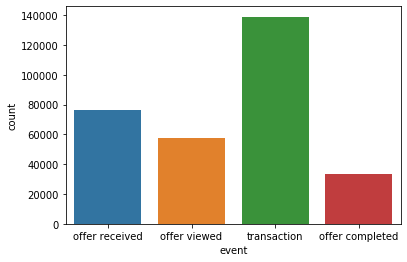

In [32]:
# visualize before breaking down
sns.countplot(x='event',data=transcript)

In [33]:
receive_events = transcript[transcript.event=='offer received']
view_events = transcript[transcript.event=='offer viewed']
purchase_events = transcript[transcript.event=='transaction']
complete_events = transcript[transcript.event=='offer completed']

In [34]:
receive_events.sample(1)
view_events.sample(1)
purchase_events.sample(1)
complete_events.sample(1)

,person,event,value,time
113868,e293d9792af24d0c96beb3f3bce0e6ae,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},336


,person,event,value,time
130900,f9aa97d0dd164f8bae52c0a4f9dd9f6e,offer viewed,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},348


,person,event,value,time
234927,0a93a485420b4285949568ff618d10df,transaction,{'amount': 31.76},540


,person,event,value,time
68730,3625554b70d8411bbb8e556f686565ce,offer completed,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,168


## Clean receive_events (final data saved in df_receive_events)
There is 0 duplicated rows but one person can receive the same offer at different times

### Change value field to offer_id

In [35]:
receive_events.sample(1)

,person,event,value,time
207928,156991c53ab349b199fb03958d4e5c1f,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},504


In [36]:
receive_events['offer_id']=receive_events['value'].apply(lambda x:x['offer id'])
receive_events.head()


,person,event,value,time,offer_id
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,2906b810c7d4411798c6938adc9daaa5
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,fafdcd668e3743c1bb461111dcafc2a4
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,4d5c57ea9a6940dd891ad53e9dbe8da0


In [37]:
receive_events.isnull().mean()

person      0.0
event       0.0
value       0.0
time        0.0
offer_id    0.0
dtype: float64

In [38]:
receive_events.drop('value',axis=1,inplace=True)
receive_events.head(3)

,person,event,time,offer_id
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5


In [39]:
# check duplicates
receive_events.duplicated().sum()

0

### Customers receiving multiple offers
Customers receive 1-6 offers; more than 50% of the customers receive 4 offers or more; about20% of the user-offer pair was repeated.

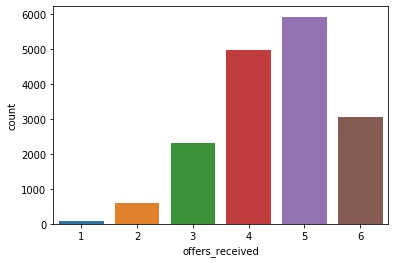

In [40]:
total_offers_received_by_customer = receive_events.groupby(['person']).offer_id.count().reset_index().rename(columns={'offer_id':'offers_received'}) # note this is counting offers; not unique offers
sns.countplot(x='offers_received',data=total_offers_received_by_customer)

In [41]:
total_offers_received_by_customer['offers_received'].value_counts()/len(total_offers_received_by_customer['offers_received'])

5    0.349006
4    0.293515
6    0.180475
3    0.136813
2    0.035895
1    0.004296
Name: offers_received, dtype: float64

In [42]:
### Customers receive multiple same offers
total_same_offers_received = receive_events.groupby(['person','offer_id'])['time'].count().reset_index()
total_same_offers_received['time'].value_counts()/len(total_same_offers_received['time'])

1    0.814846
2    0.166272
3    0.017760
4    0.001043
5    0.000079
Name: time, dtype: float64

### Save final receive_events data in df_receive_events

In [43]:
receive_events.sample(1)

,person,event,time,offer_id
153190,9b7cf5a50ea1407c84b87fdea5459b87,offer received,408,2906b810c7d4411798c6938adc9daaa5


In [44]:
df_receive_events = receive_events[['person','offer_id','time']].rename(columns={'person':'customer_id','time':'receive_time'})
df_receive_events.sample(1)

,customer_id,offer_id,receive_time
203879,9994b51cc1ba43ef969f4a798434ba97,4d5c57ea9a6940dd891ad53e9dbe8da0,504


## Clean view_events (final data df_view_events)

In [45]:
view_events.sample(3)

,person,event,value,time
274238,dfda168969384f4da23e2b64af1beef8,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},600
87028,68fc89081fe84717aac2ea97a41895d9,offer viewed,{'offer id': '3f207df678b143eea3cee63160fa8bed'},216
14574,1575f73eb0274ab6b25567ace5ba2a90,offer viewed,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0


In [46]:
view_events['offer_id']=view_events['value'].apply(lambda x:x['offer id'])
view_events.sample(3)

,person,event,value,time,offer_id
183026,f80eb9caef944ca899f2bef52b6c2f5e,offer viewed,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},444,ae264e3637204a6fb9bb56bc8210ddfd
51970,7d67d5d41bd547548da28696201afc21,offer viewed,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},156,0b1e1539f2cc45b7b9fa7c272da2e1d7
19160,84075839276d4b06a2b842001e527822,offer viewed,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},12,ae264e3637204a6fb9bb56bc8210ddfd


In [47]:
view_events.drop(['event','value'],axis=1,inplace=True)

In [48]:
view_events.duplicated().sum() # check duplicates

0

### How many views customers perform?
The nubmer of views per customer range from 1-6,averaged at 3.42 offers. Although the majority of the customers only view the same offer once, there are cases where customers view the same offer serveral times.

3.4290721159558037

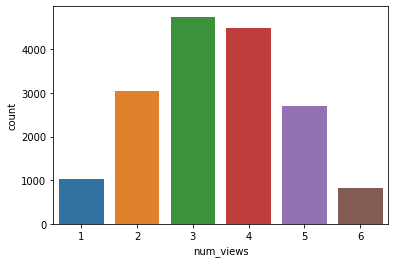

In [49]:
views_per_customer = view_events.groupby('person')['time'].count().reset_index().rename(columns ={'time':'num_views'})
sns.countplot(x='num_views',data=views_per_customer)
views_per_customer.num_views.mean()

1    0.840887
2    0.144398
3    0.013799
4    0.000834
5    0.000081
Name: event_counts, dtype: float64

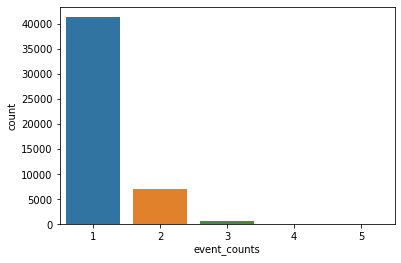

In [50]:
# customers viewing unique offers multiple times
views_per_customer_per_offer = view_events.groupby(['person','offer_id'])['time'].count().reset_index().rename(columns ={'time':'event_counts'})
sns.countplot(x='event_counts',data=views_per_customer_per_offer)     
views_per_customer_per_offer.event_counts.value_counts()/len(views_per_customer_per_offer.event_counts)

### Save final view data in df_view_events

In [51]:
df_view_events = view_events.rename(columns = {'person':'customer_id','time':'view_time'})
df_view_events.sample(3)

,customer_id,view_time,offer_id
222095,147be99d763240b4b7cbe0e024693807,516,ae264e3637204a6fb9bb56bc8210ddfd
166110,7336c1e98e9149f7b38a987c1c72614c,408,4d5c57ea9a6940dd891ad53e9dbe8da0
218142,66e315fee08a48aa858187a93887b3cc,504,ae264e3637204a6fb9bb56bc8210ddfd


## Clean purchase_events: final data df_purchase_events

In [52]:
purchase_events.sample(3)

,person,event,value,time
27799,35c748fc365a4295a3445fda28fc31b1,transaction,{'amount': 25.26},36
265320,f6540770edbb4de589eb5d0c9054e99a,transaction,{'amount': 12.18},582
264126,e4be5758c6a1433b9c3a27c62eefd1ba,transaction,{'amount': 31.69},582


### Convert 'value' to 'amount' and remove outliers

In [53]:
purchase_events['amount'] = purchase_events['value'].apply(lambda x:x['amount'])
purchase_events.amount.isnull().sum()

# remove value column
purchase_events.drop(['value'],axis=1,inplace=True)

0

In [54]:
# check duplicates
purchase_events.duplicated().sum()

0

In [55]:
# check null values 
purchase_events.isnull().mean()

person    0.0
event     0.0
time      0.0
amount    0.0
dtype: float64

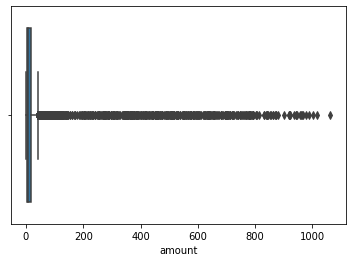

In [56]:
# visualize amount
sns.boxplot(purchase_events.amount)

The curve is extremely concentrated below 200, and skewed by extreme values above 200. We'll only keep anything within 1.5 IQR

In [57]:
purchase_events_clean = purchase_events # initialize the clean dataset 

# calculate IQR scores
Q1 = purchase_events.amount.quantile(0.25)
Q3 = purchase_events.amount.quantile(0.75)
IQR = Q3 - Q1
           
# remove outliners
purchase_events_clean = purchase_events[(purchase_events.amount> Q1-1.5*IQR) & (purchase_events.amount < Q3+1.5*IQR)]

# check shapes
purchase_events.shape
purchase_events_clean.shape

(138953, 4)

(137717, 4)

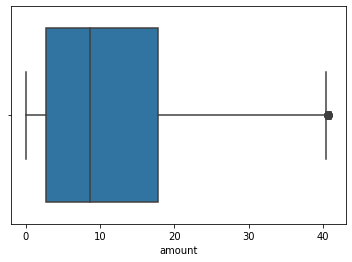

In [58]:
# check distribution
sns.boxplot(purchase_events_clean.amount)

###

In [59]:
df_purchase_events = purchase_events_clean[['person','time','amount']].rename(columns={'person':'customer_id','time':'purchase_time','amount':'purchase_amount'})
df_purchase_events.sample(5)

,customer_id,purchase_time,purchase_amount
267365,3c10ab432bde490f8bc2d294eb220e60,588,3.28
184555,b8fc056d443741cf8f1219e036c6c369,444,18.18
42379,37dfdf86ca2044d4a4e0a2eb2904c12c,102,19.30
91207,3629e20bb15a4d61a1f5bbf9d138c8f4,234,3.45
283655,f5b6da50d5f044448c3de0590e9cab29,624,20.78


## Clean complete_events: saved in df_complete_events

In [60]:
complete_events.shape
complete_events.head()

(33579, 4)

,person,event,value,time
12658,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,offer completed,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...,0
12672,fe97aa22dd3e48c8b143116a8403dd52,offer completed,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,0
12679,629fc02d56414d91bca360decdfa9288,offer completed,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,0
12692,676506bad68e4161b9bbaffeb039626b,offer completed,{'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd...,0
12697,8f7dd3b2afe14c078eb4f6e6fe4ba97d,offer completed,{'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0...,0


In [61]:
complete_events['offer_id'] = complete_events['value'].apply(lambda x:x['offer_id'])
complete_events.drop(['value','event'],axis=1,inplace=True)


In [62]:
complete_events.rename(columns={'person':'customer_id','time':'complete_time'},inplace=True)
complete_events.shape
complete_events.head(3)

(33579, 3)

,customer_id,complete_time,offer_id
12658,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,2906b810c7d4411798c6938adc9daaa5
12672,fe97aa22dd3e48c8b143116a8403dd52,0,fafdcd668e3743c1bb461111dcafc2a4
12679,629fc02d56414d91bca360decdfa9288,0,9b98b8c7a33c4b65b9aebfe6a799e6d9


In [63]:
df_complete_events = complete_events

# Data Consolidation and Processing
We now have our clean data in: 

- df_offers
- df_customers
- df_receive_events
- df_view_events
- df_purchase_events
- df_complete_events

In [64]:
df_offers.sample(1)
df_customers.sample(1)
df_receive_events.sample(1)
df_view_events.sample(1)
df_purchase_events.sample(1)

,is_bogo,is_discount,is_informational,reward,difficulty,offer_id,has_email,has_web,has_mobile,has_social,duration_hours
1,1,0,0,10,10,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,120


,customer_id,income,membership_days,age,is_female,is_male
6126,e19dbea1ad994f46827cde9f20ee9042,35000.0,270.0,23,1,0


,customer_id,offer_id,receive_time
65134,aab3fcd70ca74dd59cf056d61b70e906,4d5c57ea9a6940dd891ad53e9dbe8da0,168


,customer_id,view_time,offer_id
133017,7f11b9f1960f4516ac628a07622cf833,354,4d5c57ea9a6940dd891ad53e9dbe8da0


,customer_id,purchase_time,purchase_amount
38328,409e23b7a2dd4359a79303fe3898d9a9,84,4.99


## Left join df_receive_events with df_customers: saved as df_receive_customers

In [65]:
df_receive_customers = pd.merge(df_receive_events,df_customers,how='left',on='customer_id')

# check shapes of dataframes before and after joins
df_receive_events.shape
df_customers.shape
df_receive_customers.shape

(76277, 3)

(14825, 6)

(76277, 8)

In [66]:
# some receive events do not find a match in the customers. This is expected because we removed customers with odd ages.
df_receive_customers.isnull().mean()

customer_id        0.000000
offer_id           0.000000
receive_time       0.000000
income             0.128164
membership_days    0.128164
age                0.128164
is_female          0.128164
is_male            0.128164
dtype: float64

,customer_id,age,is_female,membership_days,offer_count
0,0009655768c64bdeb2e877511632db8f,33.0,0.0,461.0,5
1,0011e0d4e6b944f998e987f904e8c1e5,40.0,0.0,198.0,5
2,0020c2b971eb4e9188eac86d93036a77,59.0,1.0,874.0,5
3,0020ccbbb6d84e358d3414a3ff76cffd,24.0,1.0,622.0,4
4,003d66b6608740288d6cc97a6903f4f0,26.0,1.0,400.0,5


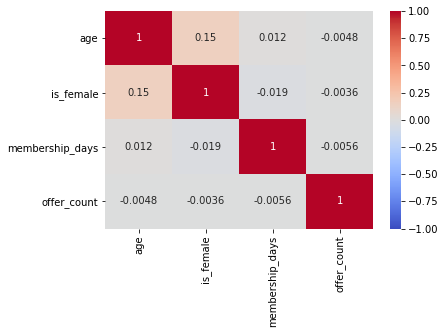

In [67]:
# now we can see e.g. if different demogrpahics groups differ in terms of receiving offers 
offer_counts_per_customer = df_receive_customers.groupby(['customer_id','age','is_female','membership_days'])['offer_id'].count().reset_index().rename(columns={'offer_id':'offer_count'})
offer_counts_per_customer.head()
sns.heatmap(offer_counts_per_customer.corr(),annot=True,cmap='coolwarm',vmin=-1)


There are no obvious trend between customers' age, gender, membership days with the number of offers they receive

## Left join: df_receive_customers with df_view_events

In [68]:
df_receive_customers.sample(2)
df_view_events.sample(2)

,customer_id,offer_id,receive_time,income,membership_days,age,is_female,is_male
18915,135b0e8d3c7c4440be4ebca74ea9fb84,2298d6c36e964ae4a3e7e9706d1fb8c2,168,40000.0,1801.0,54.0,0.0,1.0
42355,ffaecba5bbb14cffb04c2490d18eee7e,0b1e1539f2cc45b7b9fa7c272da2e1d7,408,86000.0,330.0,50.0,0.0,1.0


,customer_id,view_time,offer_id
286302,c4196572916f4e7a8a5e6b0c18c7dd40,636,5a8bc65990b245e5a138643cd4eb9837
85170,3945da252ea34e7f964537e00c053b2e,210,f19421c1d4aa40978ebb69ca19b0e20d


In [69]:
df_receive_view_customers = pd.merge(df_receive_customers,df_view_events,how='left',on=['customer_id','offer_id'])
df_receive_view_customers.head()

,customer_id,offer_id,receive_time,income,membership_days,age,is_female,is_male,view_time
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,100000.0,443.0,75.0,1.0,0.0,6.0
1,a03223e636434f42ac4c3df47e8bac43,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,NaN,NaN,NaN,NaN,NaN,6.0
2,a03223e636434f42ac4c3df47e8bac43,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,NaN,NaN,NaN,NaN,NaN,624.0
3,e2127556f4f64592b11af22de27a7932,2906b810c7d4411798c6938adc9daaa5,0,70000.0,91.0,68.0,0.0,1.0,18.0
4,8ec6ce2a7e7949b1bf142def7d0e0586,fafdcd668e3743c1bb461111dcafc2a4,0,NaN,NaN,NaN,NaN,NaN,12.0


In [70]:
# check shapes
df_receive_view_customers.shape
df_receive_customers.shape
df_view_events.shape

(95321, 9)

(76277, 8)

(57725, 3)

Noticed that some rows in df_receive_customers are matched to multiple view_events; we will have to clean it later

## Combine df_receive_view_customers with df_offers, save in df_receive_view_customers_offers_clean

In [71]:
df_receive_view_customers_offers = pd.merge(df_receive_view_customers,df_offers,on='offer_id',how='left')
df_receive_view_customers_offers.shape
df_receive_view_customers_offers.head()

(95321, 19)

,customer_id,offer_id,receive_time,income,membership_days,age,is_female,is_male,view_time,is_bogo,is_discount,is_informational,reward,difficulty,has_email,has_web,has_mobile,has_social,duration_hours
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,100000.0,443.0,75.0,1.0,0.0,6.0,1,0,0,5,5,1,1,1,0,168
1,a03223e636434f42ac4c3df47e8bac43,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,NaN,NaN,NaN,NaN,NaN,6.0,0,1,0,5,20,1,1,0,0,240
2,a03223e636434f42ac4c3df47e8bac43,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,NaN,NaN,NaN,NaN,NaN,624.0,0,1,0,5,20,1,1,0,0,240
3,e2127556f4f64592b11af22de27a7932,2906b810c7d4411798c6938adc9daaa5,0,70000.0,91.0,68.0,0.0,1.0,18.0,0,1,0,2,10,1,1,1,0,168
4,8ec6ce2a7e7949b1bf142def7d0e0586,fafdcd668e3743c1bb461111dcafc2a4,0,NaN,NaN,NaN,NaN,NaN,12.0,0,1,0,2,10,1,1,1,1,240


### Compute offer_expiry_time

In [72]:
df_receive_view_customers_offers['expiry_time']=df_receive_view_customers_offers['receive_time']+df_receive_view_customers_offers['duration_hours']


In [73]:
df_receive_view_customers_offers.head()

,customer_id,offer_id,receive_time,income,membership_days,age,is_female,is_male,view_time,is_bogo,is_discount,is_informational,reward,difficulty,has_email,has_web,has_mobile,has_social,duration_hours,expiry_time
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,100000.0,443.0,75.0,1.0,0.0,6.0,1,0,0,5,5,1,1,1,0,168,168
1,a03223e636434f42ac4c3df47e8bac43,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,NaN,NaN,NaN,NaN,NaN,6.0,0,1,0,5,20,1,1,0,0,240,240
2,a03223e636434f42ac4c3df47e8bac43,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,NaN,NaN,NaN,NaN,NaN,624.0,0,1,0,5,20,1,1,0,0,240,240
3,e2127556f4f64592b11af22de27a7932,2906b810c7d4411798c6938adc9daaa5,0,70000.0,91.0,68.0,0.0,1.0,18.0,0,1,0,2,10,1,1,1,0,168,168
4,8ec6ce2a7e7949b1bf142def7d0e0586,fafdcd668e3743c1bb461111dcafc2a4,0,NaN,NaN,NaN,NaN,NaN,12.0,0,1,0,2,10,1,1,1,1,240,240


### Filter out views after expiry time (due to multi-matches)

In [74]:
df_receive_view_customers_offers.isnull().mean()

customer_id         0.000000
offer_id            0.000000
receive_time        0.000000
income              0.130999
membership_days     0.130999
age                 0.130999
is_female           0.130999
is_male             0.130999
view_time           0.167770
is_bogo             0.000000
is_discount         0.000000
is_informational    0.000000
reward              0.000000
difficulty          0.000000
has_email           0.000000
has_web             0.000000
has_mobile          0.000000
has_social          0.000000
duration_hours      0.000000
expiry_time         0.000000
dtype: float64

In [75]:
df_receive_view_customers_offers_clean = df_receive_view_customers_offers.drop(
                                         df_receive_view_customers_offers[(df_receive_view_customers_offers.view_time <= df_receive_view_customers_offers.receive_time) | (df_receive_view_customers_offers.view_time >= df_receive_view_customers_offers.expiry_time)]
                                         .index,axis=0)
df_receive_view_customers_offers_clean.shape

(61694, 20)

## Combine df_receive_view_customers_offers_clean with completion data

In [76]:
df_receive_view_customers_offers_clean.shape
df_receive_view_customers_offers_clean.sample(1)
df_complete_events.shape
df_complete_events.sample(1)

(61694, 20)

,customer_id,offer_id,receive_time,income,membership_days,age,is_female,is_male,view_time,is_bogo,is_discount,is_informational,reward,difficulty,has_email,has_web,has_mobile,has_social,duration_hours,expiry_time
87352,b9c2811b721840d7a4b38bcad4c938e0,f19421c1d4aa40978ebb69ca19b0e20d,576,49000.0,371.0,46.0,0.0,1.0,612.0,1,0,0,5,5,1,1,1,1,120,696


(33579, 3)

,customer_id,complete_time,offer_id
236874,6a3c9777a6fe4dcd8271eb0a67c8b533,546,2906b810c7d4411798c6938adc9daaa5


In [77]:
df_combined = pd.merge(df_receive_view_customers_offers_clean,df_complete_events, how ='left',on=['customer_id','offer_id'])
df_combined.shape
df_combined.sample(3)

(70289, 21)

,customer_id,offer_id,receive_time,income,membership_days,age,is_female,is_male,view_time,is_bogo,...,is_informational,reward,difficulty,has_email,has_web,has_mobile,has_social,duration_hours,expiry_time,complete_time
56318,3f6db5f2f5054f639396afc68b59fc9d,fafdcd668e3743c1bb461111dcafc2a4,504,NaN,NaN,NaN,NaN,NaN,534.0,0,...,0,2,10,1,1,1,1,240,744,NaN
39435,9d79bfae6a7b4bb784a12d12f98bf578,4d5c57ea9a6940dd891ad53e9dbe8da0,408,60000.0,427.0,37.0,1.0,0.0,NaN,1,...,0,10,10,1,1,1,1,120,528,444.0
24562,acc03f9b3c444433997dc08615899691,0b1e1539f2cc45b7b9fa7c272da2e1d7,336,41000.0,1080.0,82.0,1.0,0.0,NaN,0,...,0,5,20,1,1,0,0,240,576,522.0


### Filter out rows with completion time earlier than receive_time, OR later than expiry time

In [78]:
df_combined = df_combined.drop(df_combined[(df_combined.complete_time <= df_combined.receive_time) | (df_combined.complete_time >= df_combined.expiry_time)]
                                .index,axis=0)

In [79]:
df_combined.shape
df_combined.head()

(60188, 21)

,customer_id,offer_id,receive_time,income,membership_days,age,is_female,is_male,view_time,is_bogo,...,is_informational,reward,difficulty,has_email,has_web,has_mobile,has_social,duration_hours,expiry_time,complete_time
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,100000.0,443.0,75.0,1.0,0.0,6.0,1,...,0,5,5,1,1,1,0,168,168,132.0
1,a03223e636434f42ac4c3df47e8bac43,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,NaN,NaN,NaN,NaN,NaN,6.0,0,...,0,5,20,1,1,0,0,240,240,NaN
2,e2127556f4f64592b11af22de27a7932,2906b810c7d4411798c6938adc9daaa5,0,70000.0,91.0,68.0,0.0,1.0,18.0,0,...,0,2,10,1,1,1,0,168,168,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,fafdcd668e3743c1bb461111dcafc2a4,0,NaN,NaN,NaN,NaN,NaN,12.0,0,...,0,2,10,1,1,1,1,240,240,NaN
4,68617ca6246f4fbc85e91a2a49552598,4d5c57ea9a6940dd891ad53e9dbe8da0,0,NaN,NaN,NaN,NaN,NaN,84.0,1,...,0,10,10,1,1,1,1,120,120,NaN


### Consolidate Multile Views to One Row
One customer-one-offer-one-receive-time should have no more than one completion event

In [80]:
# fill NaN view_time with -999999
df_combined.fillna(-999999,inplace=True)

# groupby and keep the earliest view_time
keep_columns = list(df_combined.columns)
keep_columns.remove('view_time')

# group by all other columns ,except view_time column
df_combined = df_combined.groupby(keep_columns)['view_time'].agg(['min','count']).reset_index()\
                                     .rename(columns={'min':'first_view_time','count':'view_counts'})
df_combined.sample(2)


,customer_id,offer_id,receive_time,income,membership_days,age,is_female,is_male,is_bogo,is_discount,...,difficulty,has_email,has_web,has_mobile,has_social,duration_hours,expiry_time,complete_time,first_view_time,view_counts
26701,761e483441e942d6ad4a8c84a79605ce,3f207df678b143eea3cee63160fa8bed,336,81000.0,635.0,49.0,1.0,0.0,0,0,...,0,1,1,1,0,96,432,-999999.0,408.0,1
52812,e8f410d5c3674f5ebaba29fa359ca09e,fafdcd668e3743c1bb461111dcafc2a4,336,63000.0,792.0,62.0,0.0,1.0,0,1,...,10,1,1,1,1,240,576,546.0,-999999.0,1


In [81]:
# put NaN back 
df_combined = df_combined.replace(to_replace=-999999,value=np.nan)
df_combined['view_counts'] = [b if pd.notnull(a) else (b-1) for (a,b) in zip(df_combined.first_view_time, df_combined.view_counts)]

In [82]:
# since now 'view_counts' exlucde NaNs we should consolidate the views to 'is_viewed' and 'first_view_time'
df_combined['is_viewed'] = df_combined['view_counts'].apply(lambda x: 1 if x>0 else 0)
df_combined.sample()
df_combined.drop(['view_counts'],axis=1,inplace=True)
df_combined.sample()

,customer_id,offer_id,receive_time,income,membership_days,age,is_female,is_male,is_bogo,is_discount,...,has_email,has_web,has_mobile,has_social,duration_hours,expiry_time,complete_time,first_view_time,view_counts,is_viewed
6224,1c90aacc726a4c6b8f8481465af0108e,f19421c1d4aa40978ebb69ca19b0e20d,504,50000.0,305.0,39.0,1.0,0.0,1,0,...,1,1,1,1,120,624,NaN,534.0,1,1


,customer_id,offer_id,receive_time,income,membership_days,age,is_female,is_male,is_bogo,is_discount,...,difficulty,has_email,has_web,has_mobile,has_social,duration_hours,expiry_time,complete_time,first_view_time,is_viewed
52200,e6610f34d20d4f9da23105c3ee064b7d,2298d6c36e964ae4a3e7e9706d1fb8c2,408,NaN,NaN,NaN,NaN,NaN,0,1,...,7,1,1,1,1,168,576,450.0,414.0,1


In [83]:
# check unique customer_id, offer_id, receive_time
df_combined.shape
df_combined.groupby(['customer_id','offer_id','receive_time']).size().sort_values(ascending=False).head()

# it seems possible to have one offer completed multiple times

df_combined[(df_combined.customer_id =='5ccc9ec750834277812d9a81d44debb7') & \
            (df_combined.offer_id =='fafdcd668e3743c1bb461111dcafc2a4') & \
            (df_combined.receive_time ==336)]

(57887, 22)

customer_id                       offer_id                          receive_time
2c5c63e5124e417b8504f76c868a4190  fafdcd668e3743c1bb461111dcafc2a4  336             3
edc7b04392144da9979f3077095f268a  fafdcd668e3743c1bb461111dcafc2a4  336             3
96ae94b7eb5e404bbe7a5fe07a7d7035  fafdcd668e3743c1bb461111dcafc2a4  336             3
f017b77d373f480299a8035d844286ff  fafdcd668e3743c1bb461111dcafc2a4  408             3
5ccc9ec750834277812d9a81d44debb7  fafdcd668e3743c1bb461111dcafc2a4  336             3
dtype: int64

,customer_id,offer_id,receive_time,income,membership_days,age,is_female,is_male,is_bogo,is_discount,...,difficulty,has_email,has_web,has_mobile,has_social,duration_hours,expiry_time,complete_time,first_view_time,is_viewed
21005,5ccc9ec750834277812d9a81d44debb7,fafdcd668e3743c1bb461111dcafc2a4,336,51000.0,788.0,52.0,1.0,0.0,0,1,...,10,1,1,1,1,240,576,384.0,348.0,1
21006,5ccc9ec750834277812d9a81d44debb7,fafdcd668e3743c1bb461111dcafc2a4,336,51000.0,788.0,52.0,1.0,0.0,0,1,...,10,1,1,1,1,240,576,420.0,348.0,1
21007,5ccc9ec750834277812d9a81d44debb7,fafdcd668e3743c1bb461111dcafc2a4,336,51000.0,788.0,52.0,1.0,0.0,0,1,...,10,1,1,1,1,240,576,510.0,348.0,1


In [84]:
# replace NaNs with 999999
df_combined.replace(to_replace =np.nan,value=999999,inplace=True)

# consolidate multiple completion times
keep_columns = list(df_combined.columns)
keep_columns.remove('complete_time')

df_combined = df_combined.groupby(keep_columns)['complete_time'].agg(['count','max']).reset_index()\
                          .rename(columns={'count':'complete_counts','max':'last_complete_time'})
df_combined.sample()

,customer_id,offer_id,receive_time,income,membership_days,age,is_female,is_male,is_bogo,is_discount,...,has_email,has_web,has_mobile,has_social,duration_hours,expiry_time,first_view_time,is_viewed,complete_counts,last_complete_time
39786,aff95fbae22348daa57ca6ef60a85f8c,fafdcd668e3743c1bb461111dcafc2a4,408,41000.0,150.0,59.0,0.0,1.0,0,1,...,1,1,1,1,240,648,438.0,1,1,540.0


In [85]:
df_combined.replace(to_replace = 999999,value=np.nan, inplace=True)

In [86]:
df_combined['complete_counts'] = [(a-1) if pd.isnull(b) else a for (a,b) in zip(df_combined.complete_counts,df_combined.last_complete_time)]

In [87]:
df_combined.sample(5)

,customer_id,offer_id,receive_time,income,membership_days,age,is_female,is_male,is_bogo,is_discount,...,has_email,has_web,has_mobile,has_social,duration_hours,expiry_time,first_view_time,is_viewed,complete_counts,last_complete_time
52923,ecbf6ad5e59a484a8cb3296129d3beda,2906b810c7d4411798c6938adc9daaa5,408,99000.0,876.0,69.0,0.0,1.0,0,1,...,1,1,1,0,168,576,474.0,1,1,498.0
3579,1044403864ed41af9cc17577c185abc4,2298d6c36e964ae4a3e7e9706d1fb8c2,576,39000.0,1075.0,33.0,0.0,1.0,0,1,...,1,1,1,1,168,744,696.0,1,0,NaN
46749,d08a73ea06f441009a2710c5cb2f6327,4d5c57ea9a6940dd891ad53e9dbe8da0,504,73000.0,219.0,25.0,0.0,1.0,1,0,...,1,1,1,1,120,624,522.0,1,0,NaN
35943,9f3d1ae4c6f14070a3ef5d0ef1c9d966,9b98b8c7a33c4b65b9aebfe6a799e6d9,408,55000.0,995.0,44.0,0.0,1.0,1,0,...,1,1,1,0,168,576,420.0,1,1,438.0
25986,744d603ef08c4f33af5a61c8c7628d1c,2298d6c36e964ae4a3e7e9706d1fb8c2,168,NaN,NaN,NaN,NaN,NaN,0,1,...,1,1,1,1,168,336,324.0,1,0,NaN


In [88]:
# add 'is_complete'
df_combined['is_complete']=df_combined['complete_counts'].apply(lambda x:1 if x>0 else 0)
df_combined.sample()
df_combined.drop('complete_counts',axis=1,inplace=True)
df_combined.sample()

,customer_id,offer_id,receive_time,income,membership_days,age,is_female,is_male,is_bogo,is_discount,...,has_web,has_mobile,has_social,duration_hours,expiry_time,first_view_time,is_viewed,complete_counts,last_complete_time,is_complete
52095,e8c336eb5d804723bae01588c126b222,5a8bc65990b245e5a138643cd4eb9837,336,93000.0,517.0,68.0,1.0,0.0,0,0,...,0,1,1,72,408,360.0,1,0,NaN,0


,customer_id,offer_id,receive_time,income,membership_days,age,is_female,is_male,is_bogo,is_discount,...,has_email,has_web,has_mobile,has_social,duration_hours,expiry_time,first_view_time,is_viewed,last_complete_time,is_complete
40358,b2a0d079816c4fa5b3a6797d26fec93f,ae264e3637204a6fb9bb56bc8210ddfd,576,65000.0,126.0,37.0,0.0,1.0,1,0,...,1,0,1,1,168,744,594.0,1,630.0,1


In [89]:
# check to make sure there are no duplicates
df_combined.groupby(['customer_id','offer_id','receive_time']).size().sort_values(ascending=False)

customer_id                       offer_id                          receive_time
ffff82501cea40309d5fdd7edcca4a07  fafdcd668e3743c1bb461111dcafc2a4  0               1
54ed2d25754a486fba36eb5c7541203a  0b1e1539f2cc45b7b9fa7c272da2e1d7  336             1
54f3e89d8e054759917edc94ad6a2344  fafdcd668e3743c1bb461111dcafc2a4  336             1
                                  5a8bc65990b245e5a138643cd4eb9837  504             1
                                  4d5c57ea9a6940dd891ad53e9dbe8da0  576             1
                                                                                   ..
a8eb0b8793204dff9c3f4c05b22da693  2906b810c7d4411798c6938adc9daaa5  0               1
                                  0b1e1539f2cc45b7b9fa7c272da2e1d7  168             1
a8e87d9498de4635a3d0d6e23f24d235  9b98b8c7a33c4b65b9aebfe6a799e6d9  408             1
                                                                    336             1
0009655768c64bdeb2e877511632db8f  3f207df678b143eea3cee6316

## Check completion rates before considering transaction data

In [90]:
# check completion rates of different types of offers
# bogo 
def completion_rate(df_combined,column):
    '''
    Args: df_combined - the consolidated dataframe as above 
          column -string column name
    Returns: None
    Calculate and prints completion rate when the selected column's value is 1 
    '''
    df_subset = df_combined[df_combined[column]==1]
    total_completion =  df_subset['is_complete'].sum()
    total_cases = df_subset['is_complete'].notnull().sum()
    
    completion_rate = total_completion/total_cases
    
    print("When column {} value is 1, the offer completion rate is {}".format(column,completion_rate))

# use the completion rate function 
completion_rate(df_combined,'is_bogo')
completion_rate(df_combined,'is_informational')
completion_rate(df_combined,'is_discount')

When column is_bogo value is 1, the offer completion rate is 0.5112211520988552
When column is_informational value is 1, the offer completion rate is 0.0
When column is_discount value is 1, the offer completion rate is 0.5798176807292771


The completion rate for informational offers is 0. This is as expected however asking for additional steps to process the data. Since informational offer has no conditions or codes associated.It may not have been coded as "offer_completed". We will have to, then see whether the customers have made transactions after viewing the offer to know if they are completed. 

In [91]:
completion_rate(df_combined,'is_female')
completion_rate(df_combined,'is_male')
completion_rate(df_combined,'has_email')
completion_rate(df_combined,'has_social')
completion_rate(df_combined,'has_web')
completion_rate(df_combined,'has_mobile')

When column is_female value is 1, the offer completion rate is 0.5671053280102518
When column is_male value is 1, the offer completion rate is 0.423896499238965
When column has_email value is 1, the offer completion rate is 0.436200741933226
When column has_social value is 1, the offer completion rate is 0.4777411120104601
When column has_web value is 1, the offer completion rate is 0.48203364746338173
When column has_mobile value is 1, the offer completion rate is 0.4352342927517232


We will revisit the output, since the completion rate does not include those with informational offers

## Combine df_combined with purchase_events data

In [92]:
df_purchase_events.sample(3)

,customer_id,purchase_time,purchase_amount
243216,5485849d917a4311b8c28b2dea9ad7e0,564,3.36
27472,b7dc974d1a5e4790b8e5eea0410efbf2,36,0.06
67573,46b8e16a60024d658f1df0d48883d8cb,168,3.22


In [93]:
df_combined_purchase = pd.merge(df_combined,df_purchase_events,how='left',on='customer_id')
df_combined.shape
df_purchase_events.shape
df_combined_purchase.shape
df_combined_purchase.sample(3)

(57148, 23)

(137717, 3)

(472556, 25)

,customer_id,offer_id,receive_time,income,membership_days,age,is_female,is_male,is_bogo,is_discount,...,has_mobile,has_social,duration_hours,expiry_time,first_view_time,is_viewed,last_complete_time,is_complete,purchase_time,purchase_amount
1732,01162252405b4524a8fa1bf8e6d5f04b,9b98b8c7a33c4b65b9aebfe6a799e6d9,504,32000.0,485.0,68.0,1.0,0.0,1,0,...,1,0,168,672,NaN,0,594.0,1,456.0,7.49
191193,67f05b562e2b49ce9063c9457bc83159,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,50000.0,76.0,56.0,1.0,0.0,1,0,...,1,0,168,168,NaN,0,132.0,1,402.0,9.56
438940,ed8997acdfb743058eac25c251c50da0,3f207df678b143eea3cee63160fa8bed,0,44000.0,814.0,39.0,0.0,1.0,0,0,...,1,0,96,96,48.0,1,NaN,0,402.0,4.01


In [94]:
# only keep the purchase when the purchase is between receive_time and expiry_time, and when offer is informational
df_combined_purchase = df_combined_purchase[(df_combined_purchase.receive_time <= df_combined_purchase.purchase_time) \
                                            & (df_combined_purchase.purchase_time >= df_combined_purchase.expiry_time)]
df_combined_purchase.shape

(158958, 25)

In [95]:
# compute purchase counts
purchase_counts_amount = df_combined_purchase.groupby(['customer_id','offer_id','receive_time'])['purchase_amount']\
                                             .agg(['count','sum']).reset_index()\
                                             .rename(columns={'count':'purchase_count','sum':'purchase_amount'})

purchase_counts_amount.sample(3)

,customer_id,offer_id,receive_time,purchase_count,purchase_amount
7063,2f5d16f82c0d4ff397f19610e1dbc40c,2906b810c7d4411798c6938adc9daaa5,336,2,37.88
30133,c58f31ad07c34f5689da499492aa51ca,5a8bc65990b245e5a138643cd4eb9837,336,4,22.57
29331,bfb63a0b5e364734ae7dd2d8db85ca8f,ae264e3637204a6fb9bb56bc8210ddfd,168,2,42.76


In [96]:
# combined it with df_combined again 
df_combined.shape
df_combined  = pd.merge(df_combined,purchase_counts_amount,how='left',on=['customer_id','offer_id','receive_time'])
df_combined.shape

(57148, 23)

(57148, 25)

### Assign completion status to informational offers when a valid purchase is made 

In [97]:
df_combined[df_combined.is_informational==1].head(3) # before 
df_combined['is_complete'] = [1 if ((a==1) & (b>0)) else c for (a,b,c) in zip(df_combined.is_informational,df_combined.purchase_count,df_combined.is_complete)]
df_combined[df_combined.is_informational==1].head(3) # after

,customer_id,offer_id,receive_time,income,membership_days,age,is_female,is_male,is_bogo,is_discount,...,has_mobile,has_social,duration_hours,expiry_time,first_view_time,is_viewed,last_complete_time,is_complete,purchase_count,purchase_amount
0,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,336,72000.0,461.0,33.0,0.0,1.0,0,0,...,1,0,96,432,372.0,1,NaN,0,6.0,96.87
1,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,168,72000.0,461.0,33.0,0.0,1.0,0,0,...,1,1,72,240,192.0,1,NaN,0,7.0,105.44
8,0011e0d4e6b944f998e987f904e8c1e5,3f207df678b143eea3cee63160fa8bed,0,57000.0,198.0,40.0,0.0,0.0,0,0,...,1,0,96,96,6.0,1,NaN,0,5.0,79.46


,customer_id,offer_id,receive_time,income,membership_days,age,is_female,is_male,is_bogo,is_discount,...,has_mobile,has_social,duration_hours,expiry_time,first_view_time,is_viewed,last_complete_time,is_complete,purchase_count,purchase_amount
0,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,336,72000.0,461.0,33.0,0.0,1.0,0,0,...,1,0,96,432,372.0,1,NaN,1,6.0,96.87
1,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,168,72000.0,461.0,33.0,0.0,1.0,0,0,...,1,1,72,240,192.0,1,NaN,1,7.0,105.44
8,0011e0d4e6b944f998e987f904e8c1e5,3f207df678b143eea3cee63160fa8bed,0,57000.0,198.0,40.0,0.0,0.0,0,0,...,1,0,96,96,6.0,1,NaN,1,5.0,79.46


## Check completion rate after considering purchase data

In [98]:
df_combined.shape

(57148, 25)

In [99]:
completion_rate(df_combined,'is_bogo')
completion_rate(df_combined,'is_informational')
completion_rate(df_combined,'is_discount')

When column is_bogo value is 1, the offer completion rate is 0.5112211520988552
When column is_informational value is 1, the offer completion rate is 0.8067699766254004
When column is_discount value is 1, the offer completion rate is 0.5798176807292771


In [100]:
completion_rate(df_combined,'is_female')
completion_rate(df_combined,'is_male')
completion_rate(df_combined,'has_email')
completion_rate(df_combined,'has_social')
completion_rate(df_combined,'has_web')
completion_rate(df_combined,'has_mobile')

When column is_female value is 1, the offer completion rate is 0.7308393710877815
When column is_male value is 1, the offer completion rate is 0.5877957658779577
When column has_email value is 1, the offer completion rate is 0.5992685658290754
When column has_social value is 1, the offer completion rate is 0.6167735508374322
When column has_web value is 1, the offer completion rate is 0.5876553420245065
When column has_mobile value is 1, the offer completion rate is 0.620344437161075


# Build Models

## Import packages


In [103]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import roc_curve, confusion_matrix, auc
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier

## Logistic Regression Model with Demographic Data

We first build a logistic regression model to get the baseline precision and accuracy of simple models.

* Predictors: income, membership_days, age, is_female, is_male
* outcome: (binary) has_intended_completion

In [104]:
df_combined.columns

Index(['customer_id', 'offer_id', 'receive_time', 'income', 'membership_days',
       'age', 'is_female', 'is_male', 'is_bogo', 'is_discount',
       'is_informational', 'reward', 'difficulty', 'has_email', 'has_web',
       'has_mobile', 'has_social', 'duration_hours', 'expiry_time',
       'first_view_time', 'is_viewed', 'last_complete_time', 'is_complete',
       'purchase_count', 'purchase_amount'],
      dtype='object')

In [105]:
# are there offers completed without viewed? 
df_combined[(df_combined.is_viewed ==0) & (df_combined.is_complete==1)].shape[0]/df_combined.shape[0]

0.12964583187513123

About 11% of the completions took place before viewing the offer

In [106]:
pd.crosstab(df_combined.is_viewed,df_combined.is_complete)

is_complete,0,1
is_viewed,,
0,7794,7409
1,15107,26838


In [107]:
# exclude unintended views 
df_combined_excl_unintended_completion = df_combined.drop(df_combined[(df_combined.is_viewed==0) & (df_combined.is_complete==1)].index,axis=0 )

In [108]:
df = df_combined_excl_unintended_completion.dropna(how='any',subset=['income','age','is_female','is_male','is_complete','membership_days'])

X = df[['income','age','is_female','is_male','membership_days']]
y = df['is_complete']
y.mean()
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=41)
X_train.shape
y_train.shape
X_test.shape
y_test.shape

0.5899890271519622

(34266, 5)

(34266,)

(8567, 5)

(8567,)

In [109]:
logreg = LogisticRegression()
logreg.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [110]:
y_pred = logreg.predict(X_test)
print(classification_report(y_test, y_pred,zero_division=0))

              precision    recall  f1-score   support

           0       0.63      0.42      0.50      3537
           1       0.67      0.83      0.74      5030

    accuracy                           0.66      8567
   macro avg       0.65      0.62      0.62      8567
weighted avg       0.65      0.66      0.64      8567



This is simulated data so it is possible that seeing demographic information has no predicting power? 

## RandomForest model

In [111]:
df_combined_excl_unintended_completion.columns

Index(['customer_id', 'offer_id', 'receive_time', 'income', 'membership_days',
       'age', 'is_female', 'is_male', 'is_bogo', 'is_discount',
       'is_informational', 'reward', 'difficulty', 'has_email', 'has_web',
       'has_mobile', 'has_social', 'duration_hours', 'expiry_time',
       'first_view_time', 'is_viewed', 'last_complete_time', 'is_complete',
       'purchase_count', 'purchase_amount'],
      dtype='object')

In [112]:
df= df_combined_excl_unintended_completion[['income','membership_days','age','is_female','is_bogo','is_discount',\
                           'reward','difficulty','has_email','has_web'\
                           ,'has_mobile','has_social','is_complete']].dropna(how='any')
X = df.drop('is_complete',axis=1)
y = df['is_complete']
X.sample(2)
y.sample(2)

,income,membership_days,age,is_female,is_bogo,is_discount,reward,difficulty,has_email,has_web,has_mobile,has_social
44648,50000.0,1432.0,34.0,0.0,0,0,0,0,1,0,1,1
23689,88000.0,448.0,77.0,0.0,0,1,5,20,1,1,0,0


47107    1
54412    1
Name: is_complete, dtype: int64

In [113]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=2)
X_train.shape
y_train.shape
X_test.shape
y_test.shape

(34266, 12)

(34266,)

(8567, 12)

(8567,)

In [114]:
param_grid = {
    'criterion' : ['gini', 'entropy'],
    'max_depth' : [2,5,10],
    'min_samples_split' : [10,50,100],
    'min_samples_leaf' : [2,5,10]
}



model = GridSearchCV(estimator=RandomForestClassifier(random_state=42), 
                              param_grid=param_grid, cv=2, scoring='f1')

In [115]:
model.fit(X_train, y_train)

GridSearchCV(cv=2, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=42,
                                  

In [116]:
model.best_params_

{'criterion': 'entropy',
 'max_depth': 10,
 'min_samples_leaf': 10,
 'min_samples_split': 100}

In [117]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.70      0.62      0.66      3498
           1       0.76      0.81      0.78      5069

    accuracy                           0.74      8567
   macro avg       0.73      0.72      0.72      8567
weighted avg       0.73      0.74      0.73      8567



## RandomForest model considering customers making unintended completions

In [118]:
df_combined.sample(3)

,customer_id,offer_id,receive_time,income,membership_days,age,is_female,is_male,is_bogo,is_discount,...,has_mobile,has_social,duration_hours,expiry_time,first_view_time,is_viewed,last_complete_time,is_complete,purchase_count,purchase_amount
46688,d0532474533d4dcaa552813f36898506,0b1e1539f2cc45b7b9fa7c272da2e1d7,408,34000.0,871.0,57.0,1.0,0.0,0,1,...,0,0,240,648,NaN,0,NaN,0,2.0,3.35
51984,e82923736a10439db3aae5eb942999d5,4d5c57ea9a6940dd891ad53e9dbe8da0,576,68000.0,618.0,64.0,0.0,1.0,1,0,...,1,1,120,696,624.0,1,594.0,1,1.0,26.17
28273,7e5b86cde767403b85683543c5183817,ae264e3637204a6fb9bb56bc8210ddfd,0,41000.0,1076.0,54.0,0.0,1.0,1,0,...,1,1,168,168,72.0,1,36.0,1,17.0,39.70


Create a offer_influenced field, where, when the offer is completed after viewed, set offer_influenced to 1; 
when the offer is completed without purchase, set the offer_influenced to 0 

In [119]:
df_combined['is_influenced'] = [1 if ((a==1) & (b==1)) else 0 for a,b in zip(df_combined.is_viewed,df_combined.is_complete)] 




In [120]:
df= df_combined[['income','membership_days','age','is_female','is_bogo','is_discount',\
                           'reward','difficulty','has_email','has_web'\
                           ,'has_mobile','has_social','is_influenced']].dropna(how='any')
X = df.drop('is_influenced',axis=1)
y = df['is_influenced']
X.sample(2)
y.sample(2)

,income,membership_days,age,is_female,is_bogo,is_discount,reward,difficulty,has_email,has_web,has_mobile,has_social
48421,61000.0,191.0,47.0,1.0,1,0,5,5,1,1,1,0
1969,55000.0,263.0,64.0,0.0,1,0,5,5,1,1,1,0


5260    1
7832    0
Name: is_influenced, dtype: int64

In [121]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=2)
X_train.shape
y_train.shape
X_test.shape
y_test.shape
y_train.mean()
y_test.mean()

(39885, 12)

(39885,)

(9972, 12)

(9972,)

0.5087626927416322

0.49929803449659044

In [122]:
param_grid = {
    'criterion' : ['gini', 'entropy'],
    'max_depth' : [2,5,10],
    'min_samples_split' : [10,20],
    'min_samples_leaf' : [2,5,10],
    'bootstrap': [False,True],
    'n_estimators': [50, 100, 200]
}



model = GridSearchCV(estimator=RandomForestClassifier(random_state=42), 
                              param_grid=param_grid, cv=10, scoring='f1')

In [ ]:
model.fit(X_train, y_train)

In [ ]:
model.best_params_

In [ ]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

In [ ]:
# Get numerical feature importances
importances = list(model.feature_importances_)

# List of tuples with variable and importance
feature_list = X.columns
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]